# Install Transformers Library

In [1]:
!pip install transformers==2.7.0

     |████████████████████████████████| 544 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 29.4 MB/s 
     |████████████████████████████████| 895 kB 35.3 MB/s 
     |████████████████████████████████| 5.6 MB 12.9 MB/s 
     |████████████████████████████████| 131 kB 48.7 MB/s 
     |████████████████████████████████| 8.0 MB 31.6 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 138 kB 54.0 MB/s 
     |████████████████████████████████| 127 kB 48.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import transformers
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

# specify GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Load Dataset

In [31]:
df = pd.read_excel("/content/gdrive/MyDrive/BERT fine tuning/Dataset/small_dataset1.xlsx")
df.head()

,class,Symptom Severity,Delusion Score,text
0,patient,72,12,I would wake up greet my pet/friend use the ...
1,patient,92,22,"On a average Sunday I wake up, brush my teet..."
2,patient,64,4,Well This white lady moved in my hood an she...
3,control,0,0,sometimes when my family comes around and th...
4,patient,79,10,The thing that makes me the angriest is when...


In [32]:
#df = df[df['class'] == "patient"]

In [33]:
df.shape

(373, 4)

(array([190.,   0.,   0.,   8.,  29.,  39.,  41.,  26.,  32.,   8.]),
 array([  0. ,  10.3,  20.6,  30.9,  41.2,  51.5,  61.8,  72.1,  82.4,
         92.7, 103. ]),
 <a list of 10 Patch objects>)

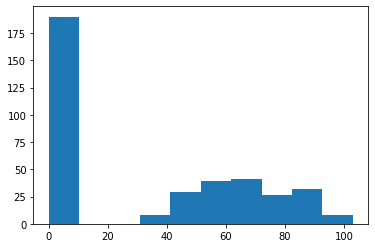

In [34]:
# check class distribution
plt.hist(df['Symptom Severity'])

# Split train dataset into train, validation and test sets

In [35]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['Symptom Severity'], 
                                                                    random_state=42, 
                                                                    test_size=0.3)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5)

### Checking if similar distribution

(array([31.,  0.,  0.,  0.,  2.,  5.,  6.,  4.,  4.,  4.]),
 array([ 0. ,  8.8, 17.6, 26.4, 35.2, 44. , 52.8, 61.6, 70.4, 79.2, 88. ]),
 <a list of 10 Patch objects>)

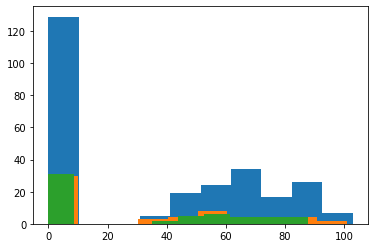

In [36]:
plt.hist(train_labels)
plt.hist(val_labels)
plt.hist(test_labels)

# Import BERT Model and BERT Tokenizer

In [37]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('/content/gdrive/MyDrive/BERT fine tuning/Models/retrained_roberta')

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(f'/content/gdrive/MyDrive/BERT fine tuning/Models/retrained_roberta')

In [38]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [39]:
# output
print(sent_id)

{'input_ids': [[0, 42, 16, 10, 741, 2399, 1421, 35950, 2], [0, 52, 40, 2051, 12, 90, 4438, 10, 741, 2399, 1421, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

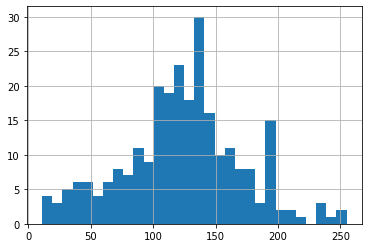

In [40]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [41]:
max_seq_len = 200

In [42]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [43]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(), dtype=torch.float32)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(), dtype=torch.float32)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist(), dtype=torch.float32)

# Create DataLoaders

In [44]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [45]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [46]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      dropout = 0.1

      # dense layer 1
      self.layers = nn.Sequential(
          nn.Linear(768,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,1)
      )

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls = self.bert(sent_id, attention_mask=mask)
      
      x = self.layers(cls)

      return x

In [47]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [48]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-4)

## Loss Function

In [49]:
# loss function
loss_fn  = nn.MSELoss()

# number of training epochs
epochs = 50

# Fine-Tune BERT

In [50]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = loss_fn(preds[:, 0], labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [51]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = loss_fn(preds[:, 0],labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [52]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50

Evaluating...

Training Loss: 2359.292
Validation Loss: 2022.333

 Epoch 2 / 50

Evaluating...

Training Loss: 2509.115
Validation Loss: 2014.032

 Epoch 3 / 50

Evaluating...

Training Loss: 2836.151
Validation Loss: 1970.322

 Epoch 4 / 50

Evaluating...

Training Loss: 2332.802
Validation Loss: 1694.532

 Epoch 5 / 50

Evaluating...

Training Loss: 1710.443
Validation Loss: 1248.750

 Epoch 6 / 50

Evaluating...

Training Loss: 1752.454
Validation Loss: 1169.975

 Epoch 7 / 50

Evaluating...

Training Loss: 1450.747
Validation Loss: 1271.781

 Epoch 8 / 50

Evaluating...

Training Loss: 1499.163
Validation Loss: 1166.233

 Epoch 9 / 50

Evaluating...

Training Loss: 1489.372
Validation Loss: 1215.766

 Epoch 10 / 50

Evaluating...

Training Loss: 1439.560
Validation Loss: 1185.184

 Epoch 11 / 50

Evaluating...

Training Loss: 1457.809
Validation Loss: 1182.174

 Epoch 12 / 50

Evaluating...

Training Loss: 1417.092
Validation Loss: 1162.905

 Epoch 13 / 50

Evaluati

# Load Saved Model

In [53]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [54]:
# get predictions for test data
model.eval()
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [55]:
preds

array([[29.301899],
       [30.049616],
       [29.482586],
       [29.547676],
       [28.620628],
       [31.112747],
       [29.31254 ],
       [28.142145],
       [31.435959],
       [29.706388],
       [29.706495],
       [29.702963],
       [28.63864 ],
       [28.119616],
       [29.417728],
       [27.513027],
       [29.105013],
       [29.366028],
       [30.90053 ],
       [31.249094],
       [29.985   ],
       [29.342543],
       [30.04839 ],
       [29.19522 ],
       [29.495838],
       [30.468275],
       [30.031992],
       [29.552513],
       [29.407112],
       [29.726877],
       [30.055128],
       [29.086779],
       [29.834269],
       [29.36301 ],
       [28.10887 ],
       [31.402332],
       [30.266912],
       [30.73463 ],
       [29.877623],
       [31.332584],
       [30.116693],
       [30.197239],
       [28.002434],
       [29.991058],
       [30.308048],
       [28.879953],
       [29.159056],
       [29.914547],
       [28.661194],
       [28.793015],


In [56]:
# model's performance
print(f"MSE: {mean_squared_error(test_y, preds)}\n MAE: {mean_absolute_error(test_y, preds)} \n R2: {r2_score(test_y, preds)}")


MSE: 1019.8532104492188
 MAE: 30.560060501098633 
 R2: 0.023166122547796264


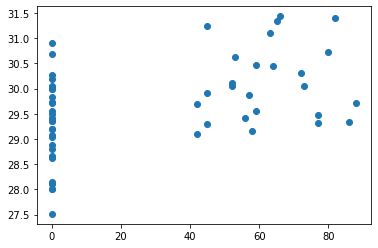

In [57]:
plt.scatter(test_y, preds)